<a href="https://colab.research.google.com/github/sruthi1014/Sentimental-analysis-of-Twitter-Data/blob/master/twitterSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Importing the necessary libraries

In [32]:
import re
import csv
import string
import nltk
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from numpy import array
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Reading the files

In [14]:
train = pd.read_csv("/content/drive/My Drive/566/train.csv")
test = pd.read_csv("/content/drive/My Drive/566/test.csv")

In [15]:
train.shape
test.shape

(10000, 4)

#### Stopwords list

In [20]:
list_stop_words = set(stopwords.words('english'))

#### Data Cleaning function - Converted to lower case, removed white spaces, punctuations, special characters and stopwords

In [21]:
def dataclean (sentimenttext):
    # Convert to lower case
    sentimenttext = sentimenttext.lower()

    # Remove www.* or https?://*
    sentimenttext = re.sub('((www\.[^\s]+)|(https?://[^\s]+))|(http?://[^\s]+)', '', sentimenttext)

    # Remove additional white spaces
    sentimenttext = re.sub('[\s]+', ' ', sentimenttext)

    # Replace #word with word and remove @word 
    sentimenttext = re.sub(r'#([^\s]+)', r'\1', sentimenttext)
    sentimenttext = re.sub(r'@([^\s]+)', '', sentimenttext) 

    # Remove special characters, punctuations and replacing apostrophe
    sentimenttext = re.sub('&[a-z]+;', '', sentimenttext)
    sentimenttext = re.sub(r'\d+', '', sentimenttext)
    sentimenttext = sentimenttext.translate(str.maketrans(string.punctuation,' '*len(string.punctuation)))
    sentimenttext = sentimenttext.replace("'", "")

    # Remove stopwords and trim
    sentimenttext = " ".join([word for word in sentimenttext.split(" ") if word not in list_stop_words])
    sentimenttext = sentimenttext.strip()

    return sentimenttext

#### Data Cleaning on train and test data

In [22]:
train["SentimentText"] = train["SentimentText"].apply(dataclean)
test["SentimentText"] = test["SentimentText"].apply(dataclean)

In [23]:
#Dropped the unnecessary columns
train = train.drop(columns=["SentimentSource"])
train = train.drop(columns=["ItemID"])

test = test.drop(columns=["SentimentSource"])
test = test.drop(columns=["ItemID"])

train_label = train["Sentiment"]
test_label = test["Sentiment"]

#### TF-IDF matrix

In [24]:
# Create a TF-IDF matrix using TfidfVectorizer. 
# On local machine we took 3000 features but on google colab we took 10000 features and ran the code

vectorizer = TfidfVectorizer(max_features = 3000)
tfidf_train = vectorizer.fit_transform(train['SentimentText']).toarray()
tfidf_test = vectorizer.transform(test['SentimentText']).toarray()

#### Logistic Regression

In [25]:
#Logistic Regression 

#sigmoid function
def sigmoid(X, weight):
    z = np.dot(X, weight)
    return 1 / (1 + np.exp(-z))

#calculating the gradient
def gradient_descent(X, h, y):
    return np.dot(X.T, (h - y)) / y.shape[0]

#updating the weights which is weight - learning rate multiplied by gradient
def updated_weight(weight, learning_rate, gradient):
    return weight - learning_rate * gradient

def predict(x, theta):
    theta_new = theta[:, np.newaxis]
    return sigmoid(x,theta_new)


# Iterate and learn the parameters
def gradient(X, y):
    num_iter = 100
    theta = np.zeros(X.shape[1])
    for i in range(num_iter):
        h = sigmoid(X, theta)
        gradient = gradient_descent(X, h, y)
        theta = updated_weight(theta, 0.1, gradient)
    return theta


# The avg probability for 0 and 1 in the training data is around 0.5 so we set the threshold for classification at this mean.          
def accuracy_score(actual, pred):
    predicted_class = ((pred >= 0.5) .astype(int))
    predicted_class = predicted_class.flatten()
    acc = np.mean(predicted_class == actual)
    return acc

#### Cross Validation

In [26]:
# Initialize 10-fold cross validation
kfold = KFold(10, True, 1)
bestaccuracy = 0
scores = np.array([])
theta_final = np.zeros(tfidf_train.shape[1])

#Splitting the train data to train and validation and Iterating over folds.
for train, test in kfold.split(tfidf_train):
    X_train = tfidf_train[train]
    X_test = tfidf_train[test]    
    Y_train = train_label[train]
    Y_test = train_label[test]


    theta_out = gradient(X_train, Y_train)
    pred = predict(X_test, theta_out)
    acc_score = accuracy_score(Y_test, pred)

#Accuracy for each fold
    scores = np.append(scores, acc_score)
    
    if(acc_score > bestaccuracy):
        theta_final = theta_out
        bestaccuracy = acc_score

print("Accuracy over 10-fold cross validations are: ", scores)
print("Mean accuracy: ", scores.mean())

Accuracy over 10-fold cross validations are:  [0.70152239 0.69907768 0.70374486 0.70218913 0.69318813 0.69896655
 0.70496722 0.69485498 0.70152239 0.69571016]
Mean accuracy:  0.6995743494850297


####  predicting on test data

In [27]:
test_predicted = predict(tfidf_test, theta_final)

#Accuracy on test data
accuracy_test = accuracy_score(test_label, test_predicted)
accuracy_test

0.7093

#### Performance (precision, recall) of the model on  test dataset.
#### Confusion Matrix

In [28]:
# Create confusion matrix
confusionMatrix = pd.DataFrame(data = confusion_matrix(test_label, (test_predicted >= 0.5) .astype(int)), columns=["0", "1"], index = ["0", "1"])
print(confusionMatrix)

      0     1
0  1756  2250
1   657  5337


#### Precision value

In [29]:
# Precision = TP/(TP + FP)
precision = round((confusionMatrix.iloc[1, 1] / (confusionMatrix.iloc[1, 1] + confusionMatrix.iloc[0, 1])) * 100, 2)
print("Precision: ", precision)

Precision:  70.34


#### Recall value

In [30]:
# Recall = TP/(TP + FN)
recall = round((confusionMatrix.iloc[1, 1] / (confusionMatrix.iloc[1, 1] + confusionMatrix.iloc[1, 0])) * 100, 2)
print("Recall: ", recall)

Recall:  89.04


####AUC-ROC Curve


In [37]:
# calculate roc curve
fpr, tpr, thresholds = metrics.roc_curve(test_label, test_predicted)
lr_auc = metrics.roc_auc_score(test_label, test_predicted)

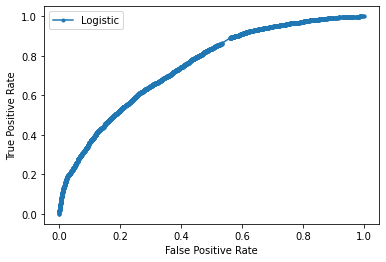

Logistic: ROC AUC=0.750


In [38]:
from matplotlib import pyplot
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print('Logistic: ROC AUC=%.3f' % (lr_auc))